In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict, namedtuple
import os 
import sys
import glob
import scipy.misc as spm
import json
import pprint
import pandas as pd
from PIL import Image
from sklearn.feature_extraction.image import extract_patches_2d
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN 5110)


In [2]:
train_data = pd.read_csv('../data/validation/train.csv')

img_03596.jpg
YFT


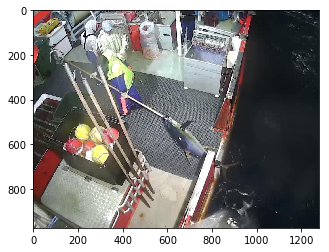

In [3]:
example = train_data.iloc[0]
print example.filename
print example.label

filename = '../data/train/{}/{}'.format(example.label, example.filename)
image = spm.imread(filename)
plt.imshow(image)
plt.show()

AttributeError: 'dict' object has no attribute 'shape'

In [22]:
patch_width = 128
patch_height = 128
DATA_FOLDER = '../Data'
bboxes = defaultdict(list)
files = glob.glob(DATA_FOLDER + '/bounding_boxes/*.json')
for ff in files:
    with open(ff) as f:
        data = json.load(f)
        for image in data:
            for annot in image['annotations']:
                bboxes[DATA_FOLDER + '/train/' + image['filename']].append((max(0, annot['x']), max(0, annot['y']), annot['width'], annot['height']))

In [21]:
#old func

# for img in bboxes:
#     for annot in img['annotations']:
#         sum_width +=  annot['width']
#         sum_height +=  annot['height']
#         bboxes[img['filename']].append((annot['x'], annot['y'], annot['width'], annot['height']))

        
        

TypeError: string indices must be integers

In [23]:
def get_patches(bbox, amount= 1):
    return extract_patches_2d(bbox, patch_size=(patch_height,patch_width), max_patches=amount, random_state=None)


In [24]:
def DoBoxesIntersect(a,b):
  return (abs(a.x - b.x) * 2 < (a.width + b.width)) and (abs(a.y - b.y) * 2 < (a.height + b.height))

In [26]:
X_train = []
y_train = []
X_test = []
y_test = []

for k,v in bboxes.iteritems():
    image = spm.imread(k)
    
    box = namedtuple('box', ['x','y','width','height'])    
    fish_boxes = []
    
    
    for b in v:
        x = int(round(b[0]))
        y = int(round(b[1]))
        width = int(round(b[2]))
        height = int(round(b[3]))
        fish_boxes.append(box(x,y,width,height))

    x = fish_boxes[0].x
    y = fish_boxes[0].y
    width = fish_boxes[0].width
    height = fish_boxes[0].height
    bbox_fish_image = image[y:y+height,x:x+width,:]    
        
    count = 0
    patches_rnd = []
    while count < 5:
        img_y = np.random.randint(image.shape[0]-patch_height)
        img_x = np.random.randint(image.shape[1]-patch_width)
        box_rnd = box(img_x, img_y, patch_width,patch_height)
        intersects = False
        for fish_box in fish_boxes:
            if DoBoxesIntersect(fish_box, box_rnd):
                intersects = True
                break
        if not intersects:
            patches_rnd.append(image[img_y:img_y+patch_height,img_x:img_x+patch_width,:])
            count += 1
            
    
    if width < patch_width or height < patch_height:
        continue
    
    patches_fish = get_patches(bbox_fish_image,amount=5)
    count = 1
    for p1,p2 in zip(patches_fish,patches_rnd):
        p1 = spm.imresize(p1,size=(64,64)).transpose(2,0,1)
        p2 = spm.imresize(p2,size=(64,64)).transpose(2,0,1)
        if count < len(patches_fish):
            X_train.append(p1)
            y_train.append(1)
            X_train.append(p2)
            y_train.append(0)
        else:
            X_test.append(p1)
            y_test.append(1)
            X_test.append(p2)
            y_test.append(0)
        count +=1
            
            
X_train = np.array(X_train).astype('float32') /255
y_train = np.array(y_train)
X_test = np.array(X_test).astype('float32') /255
y_test = np.array(y_test)


print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape


(13064L, 3L, 64L, 64L)
(13064L,)
(3266L, 3L, 64L, 64L)
(3266L,)


In [27]:
# Example how to extract the good labels
# Only using the first index, should become the largest??
height, width, co_x, co_y = None, None, None, None
with open('../data/bounding_boxes/{}_labels.json'.format(example.label.lower())) as data_file:
    data = json.load(data_file)
    for i in range(len(data)):
        path = '../data/train/{}/{}'.format(example.label, example.filename)
        if data[i]['filename'] == path:
            height = data[i]['annotations'][0]['height']
            width = data[i]['annotations'][0]['width']
            co_x = data[i]['annotations'][0]['x']
            co_y = data[i]['annotations'][0]['y']

fig, ax = plt.subplots(1)
ax.imshow(image)
plt.xlim(co_x, co_x+width)
plt.ylim(co_y, co_y+height)
plt.show()

IOError: [Errno 2] No such file or directory: '../data/bounding_boxes/yft_labels.json'

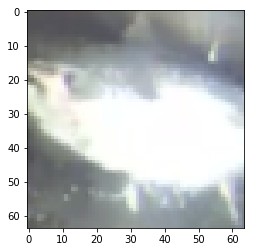

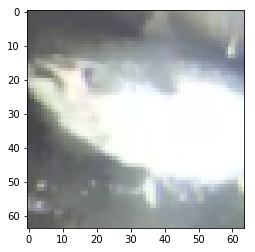

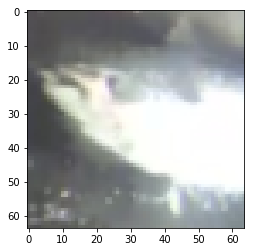

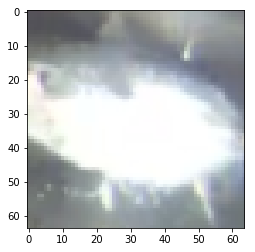

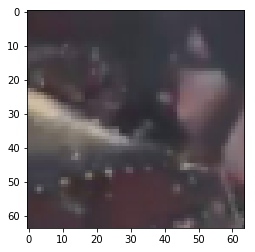

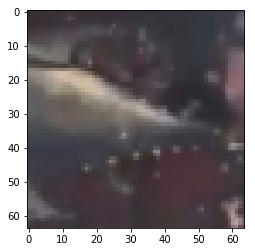

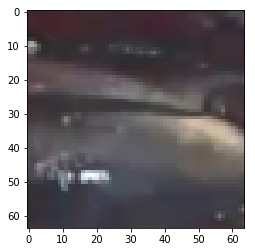

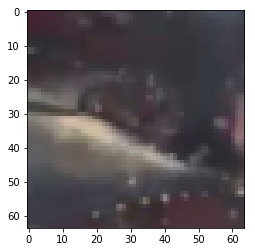

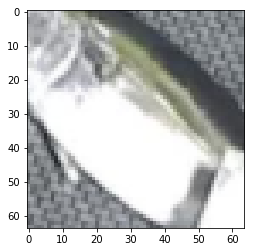

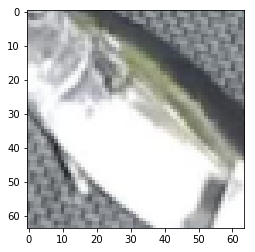

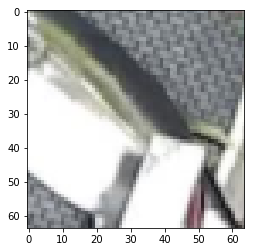

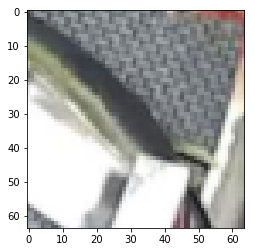

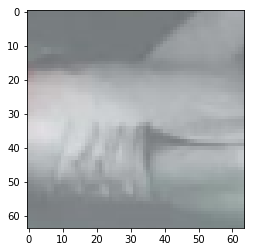

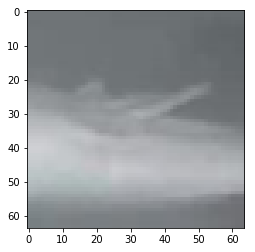

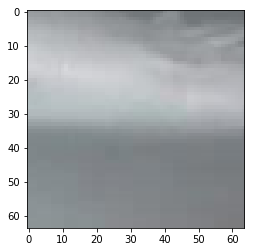

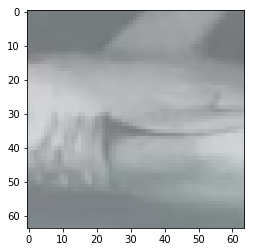

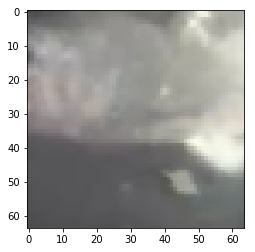

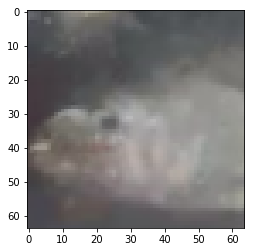

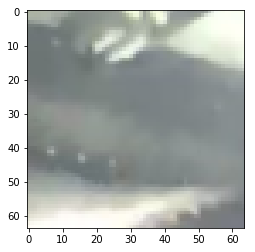

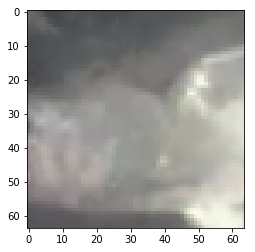

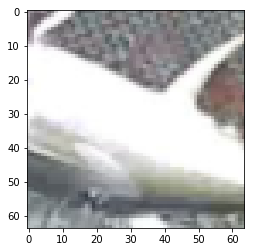

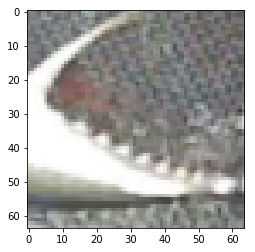

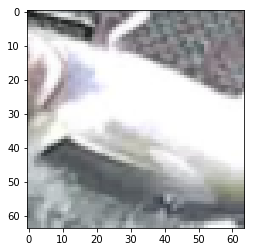

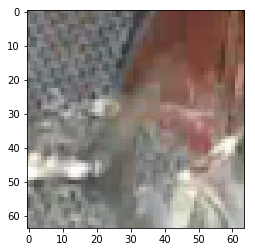

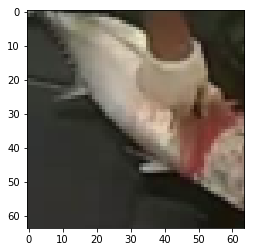

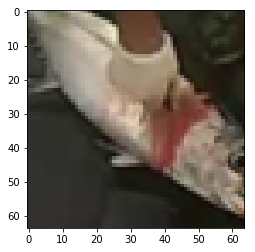

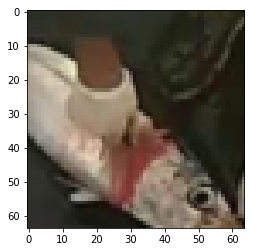

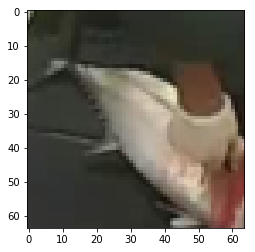

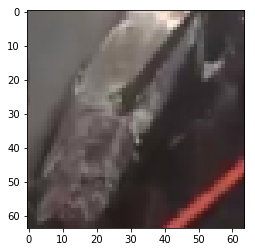

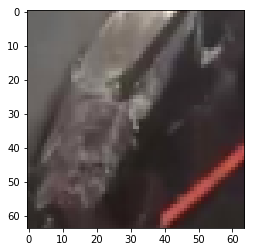

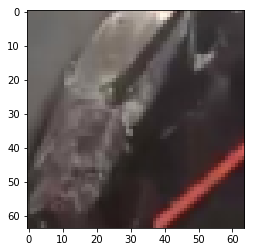

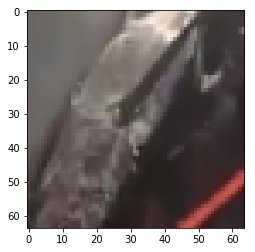

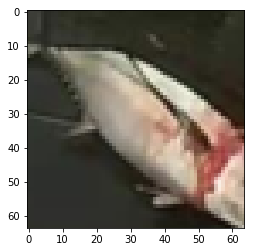

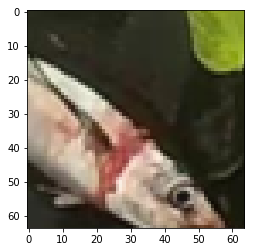

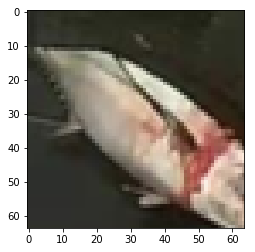

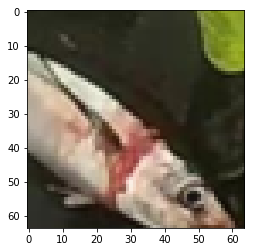

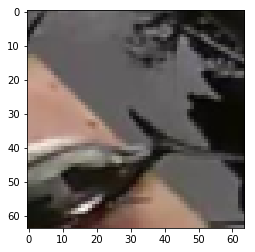

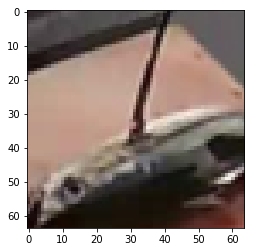

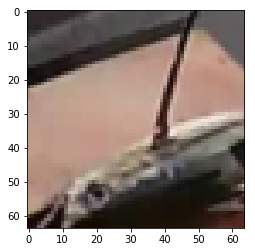

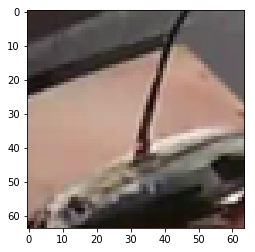

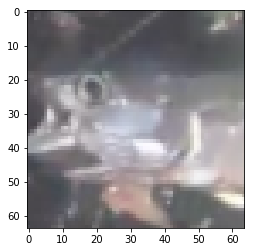

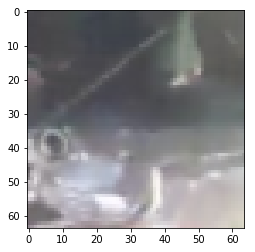

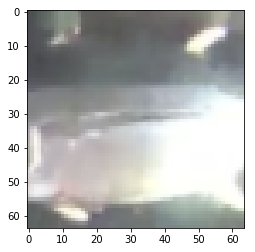

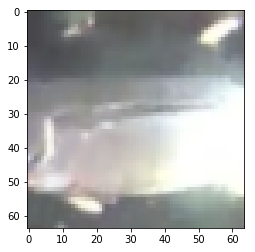

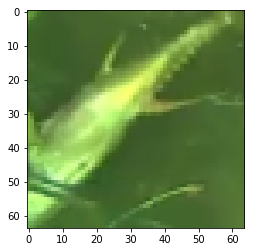

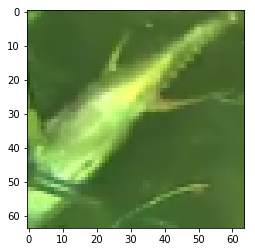

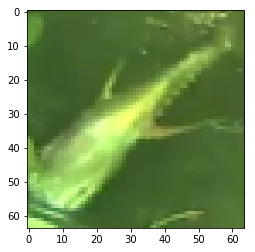

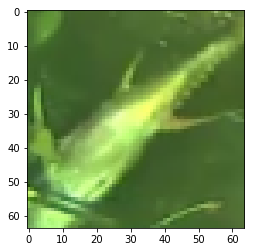

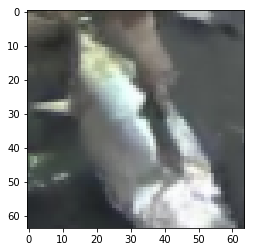

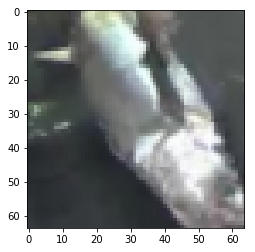

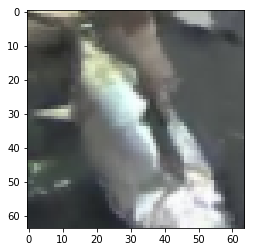

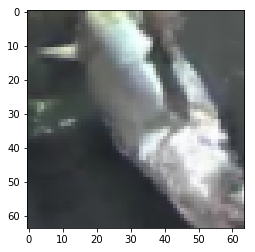

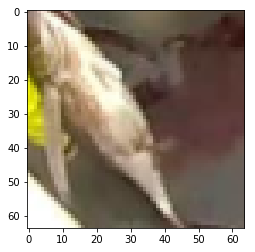

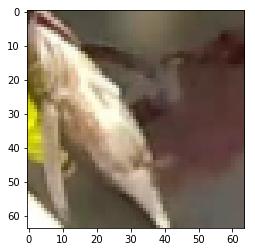

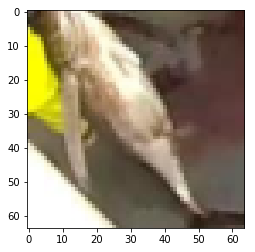

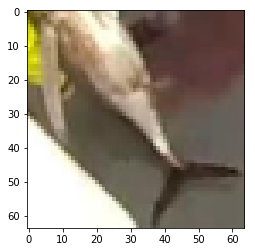

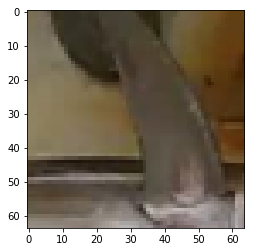

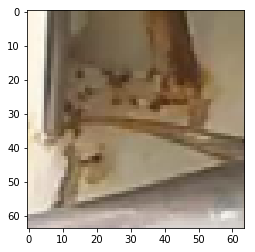

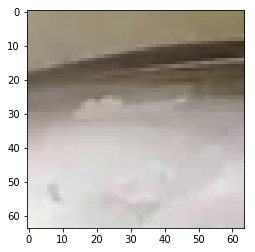

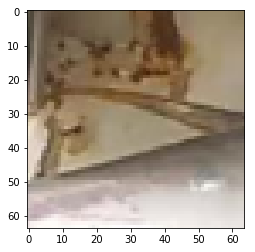

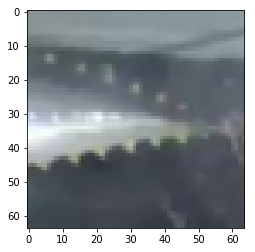

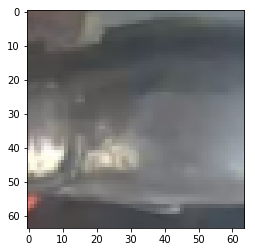

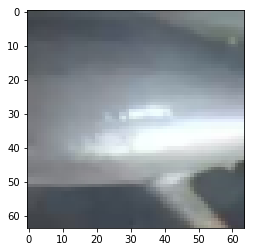

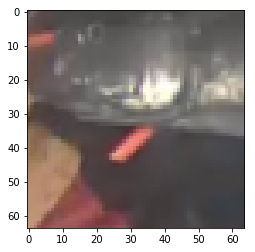

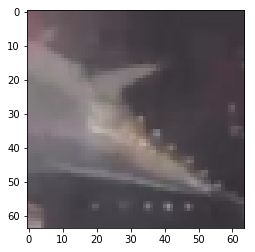

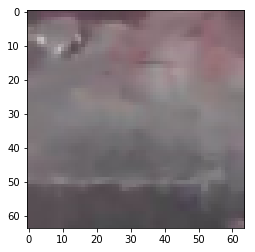

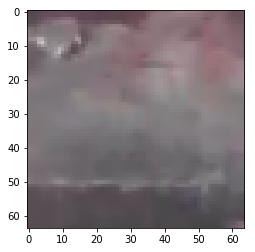

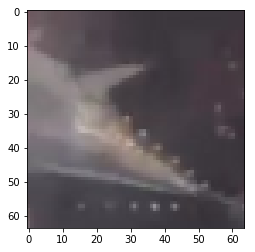

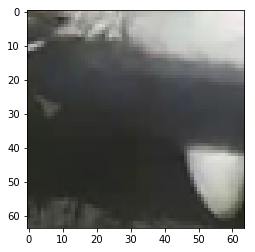

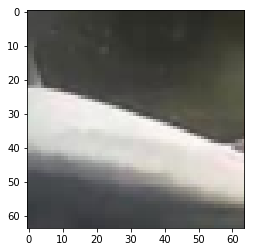

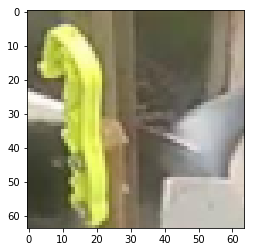

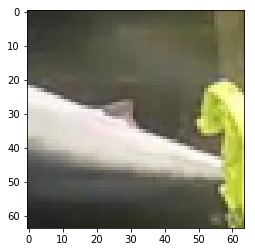

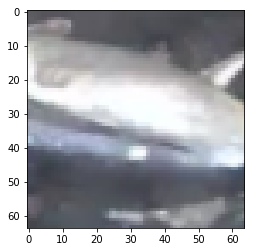

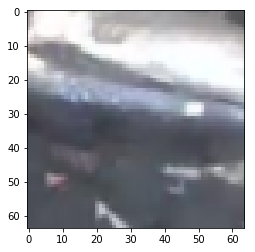

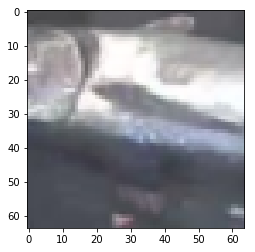

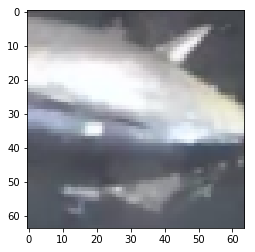

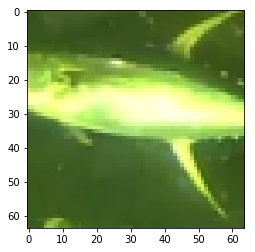

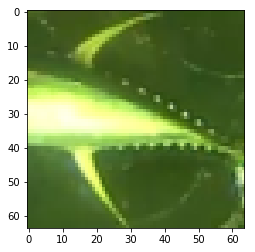

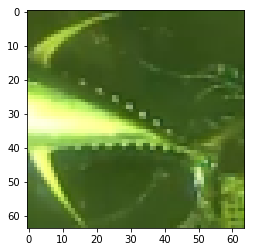

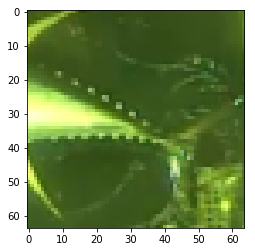

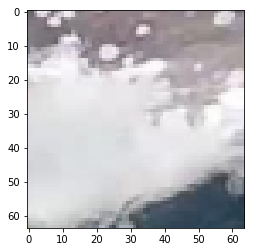

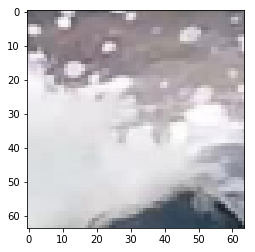

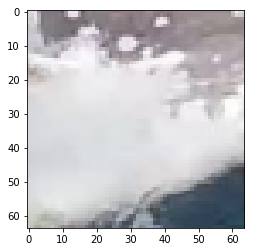

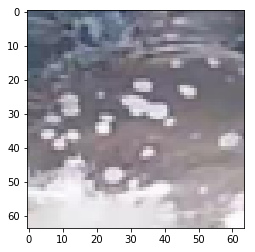

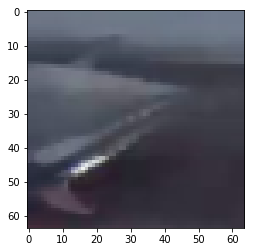

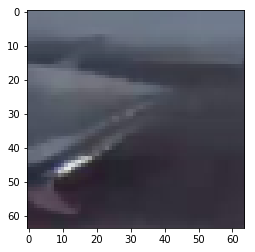

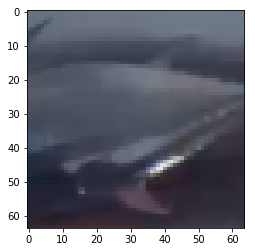

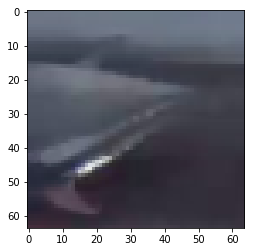

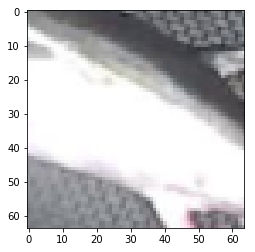

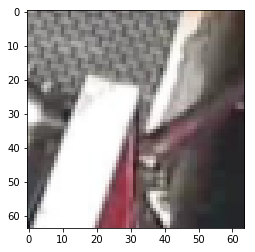

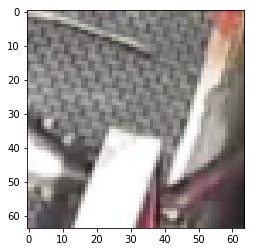

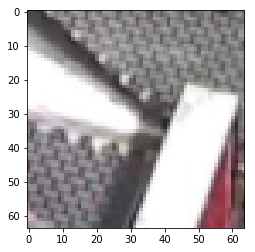

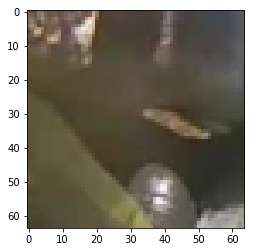

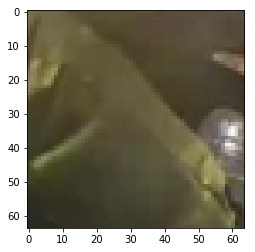

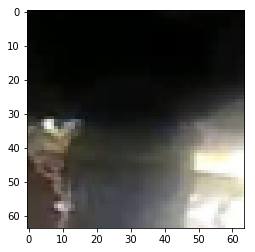

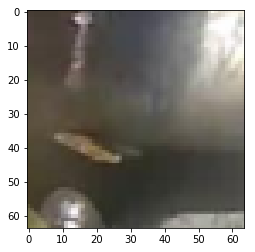

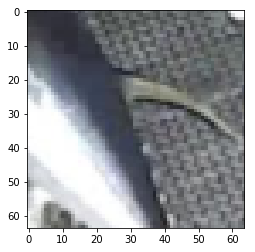

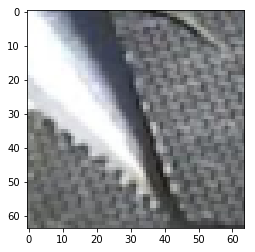

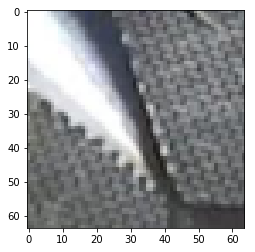

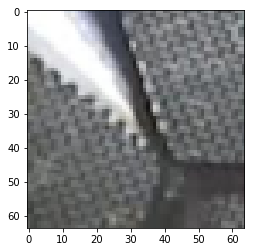

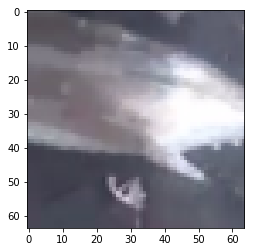

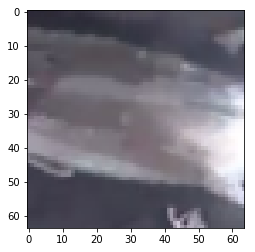

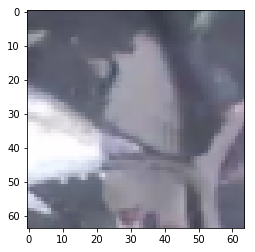

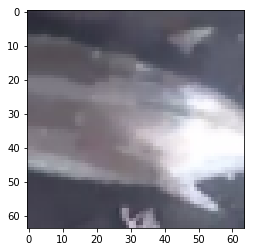

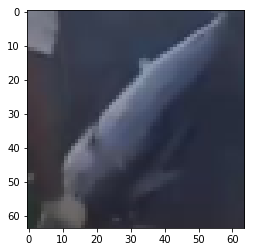

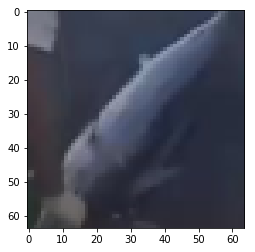

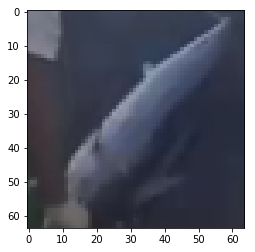

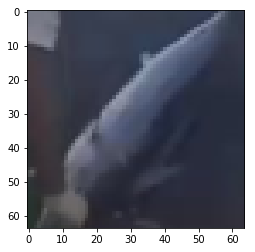

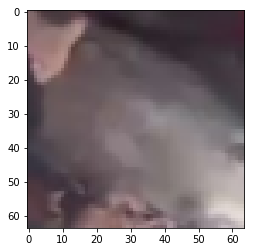

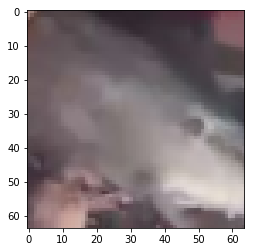

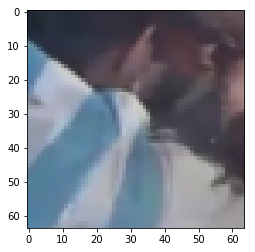

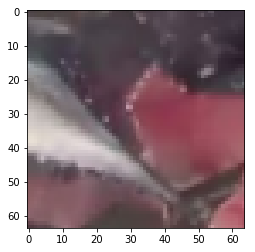

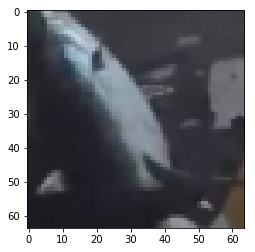

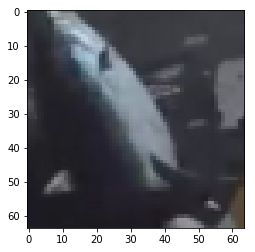

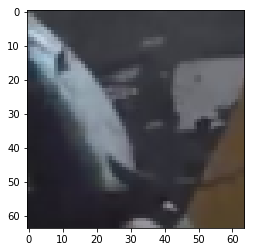

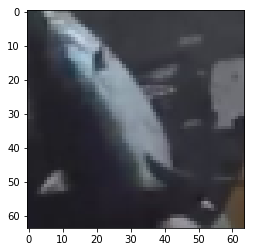

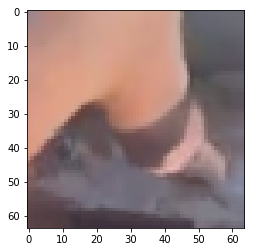

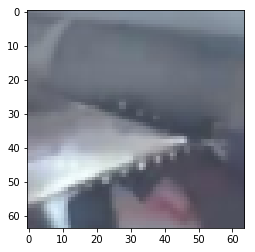

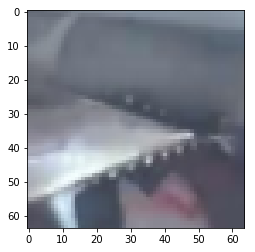

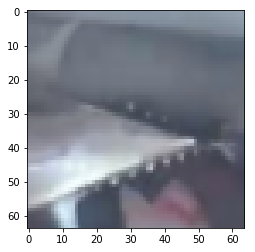

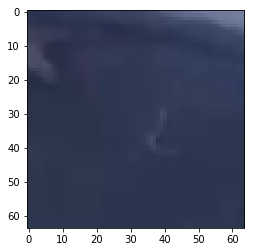

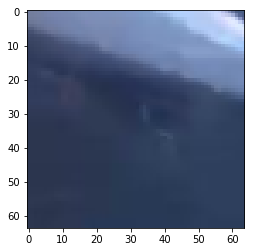

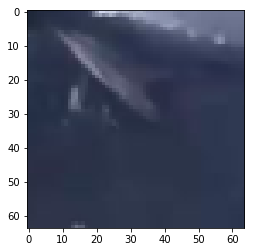

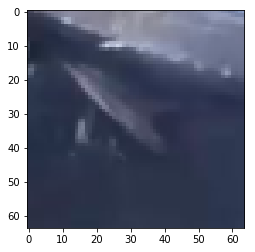

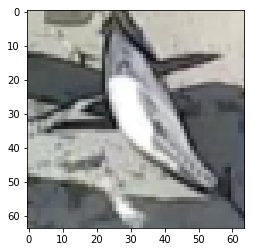

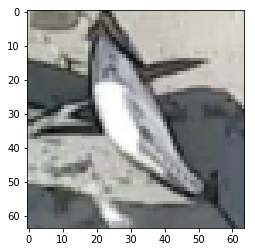

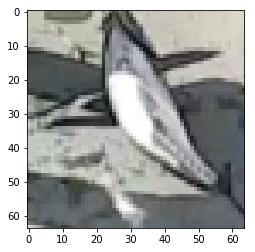

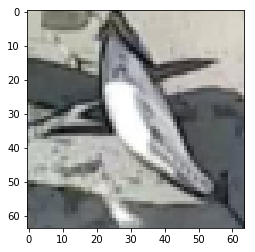

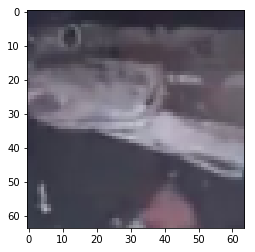

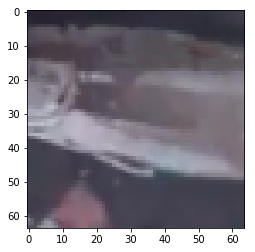

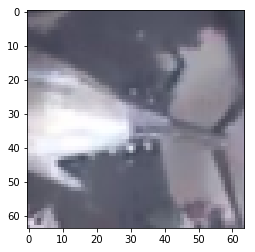

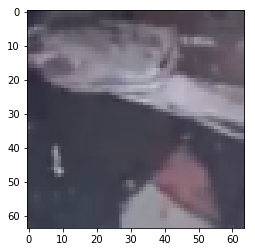

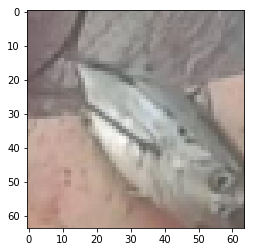

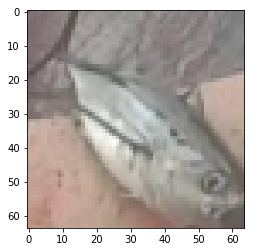

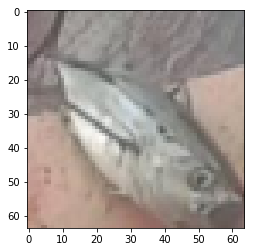

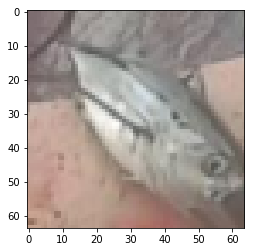

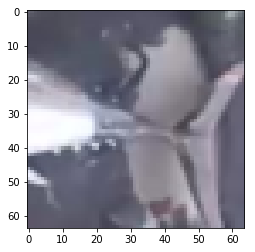

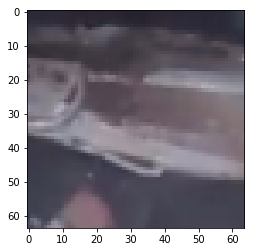

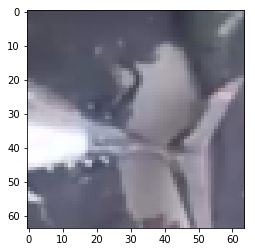

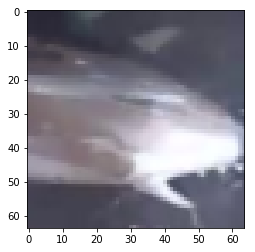

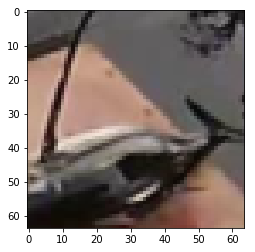

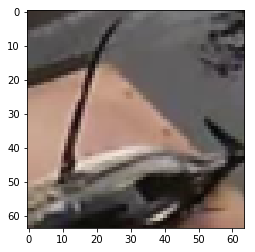

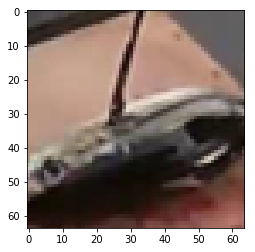

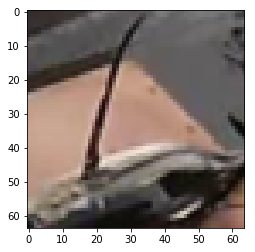

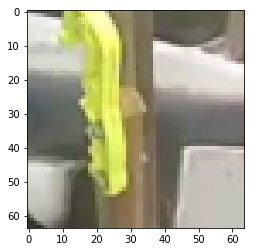

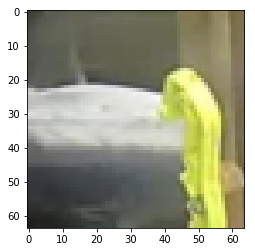

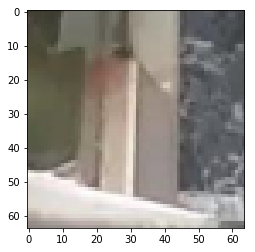

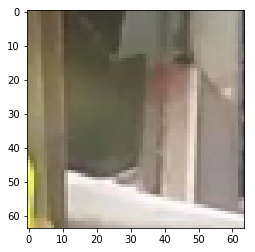

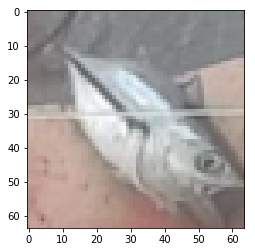

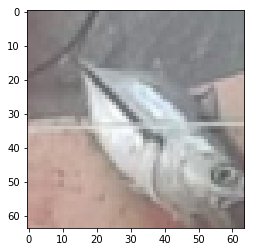

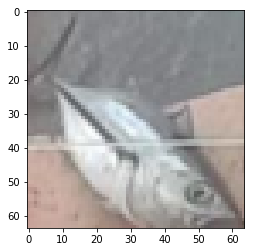

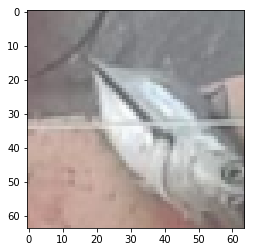

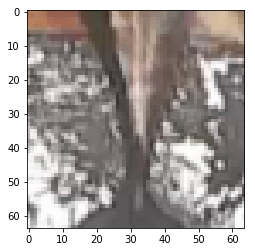

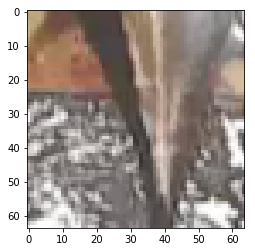

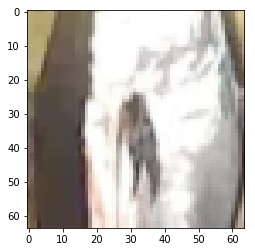

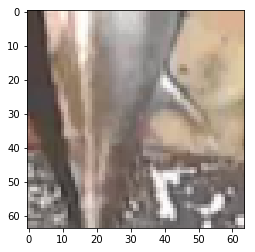

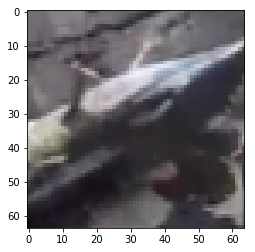

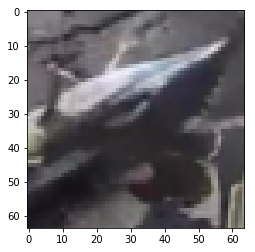

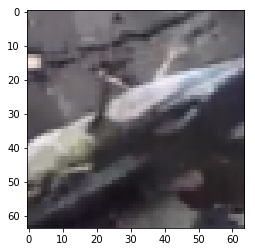

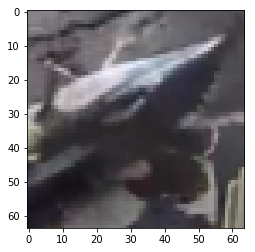

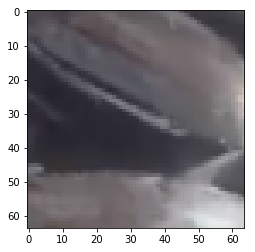

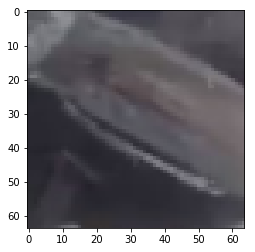

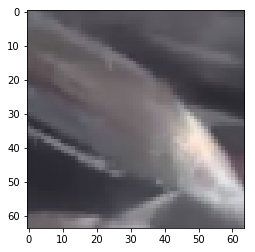

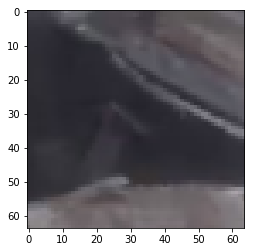

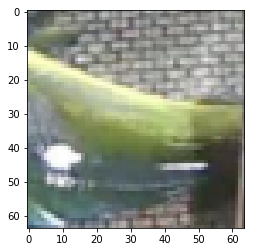

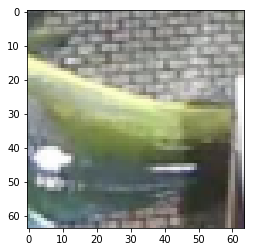

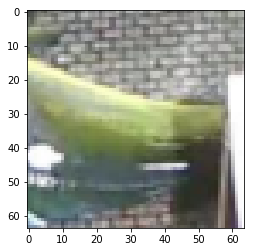

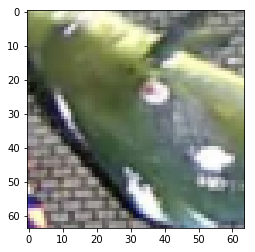

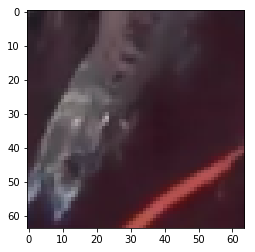

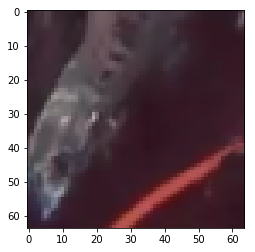

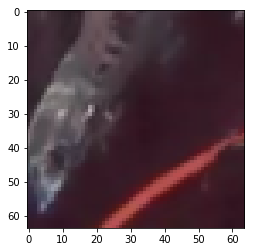

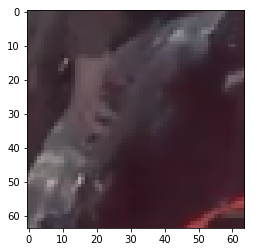

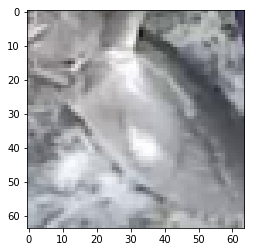

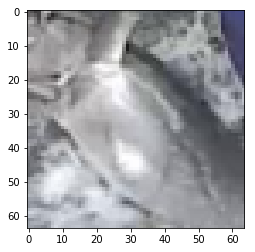

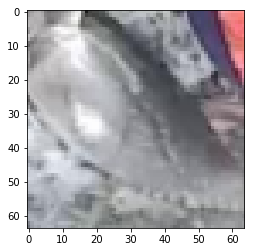

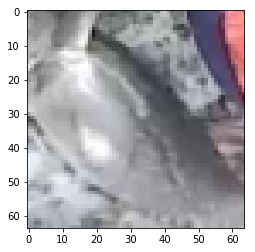

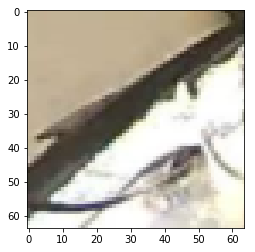

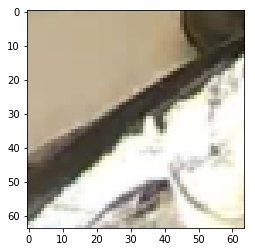

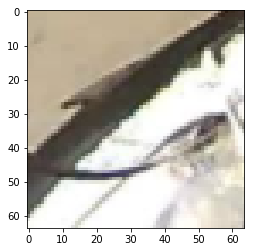

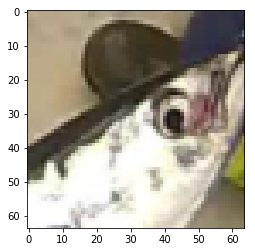

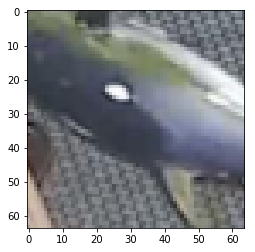

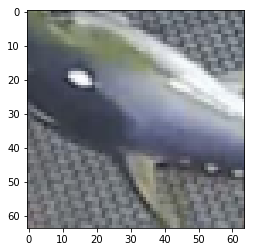

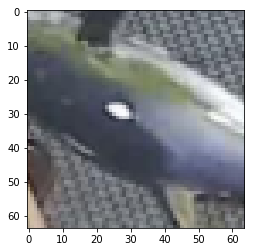

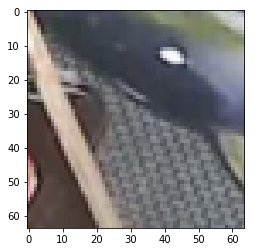

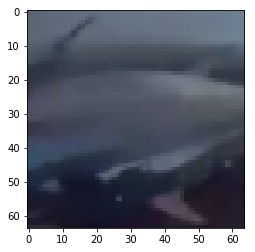

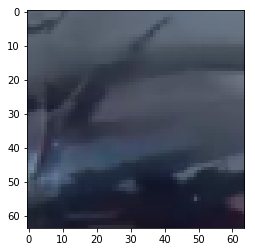

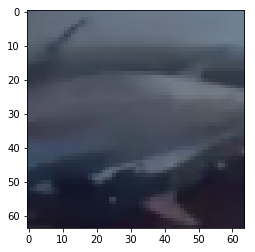

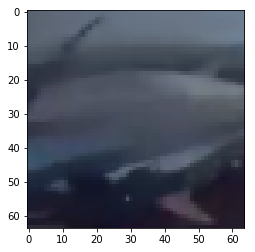

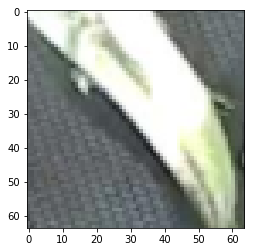

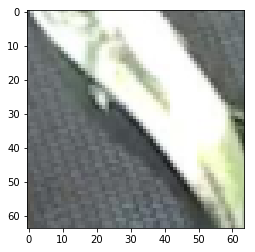

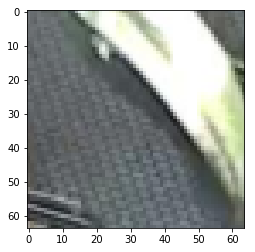

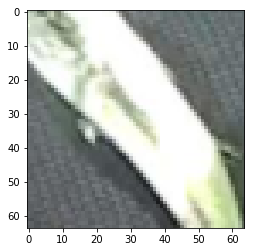

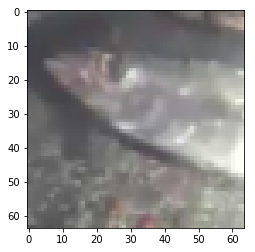

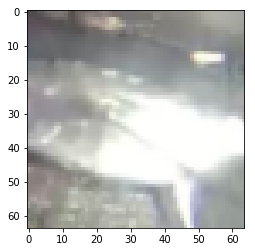

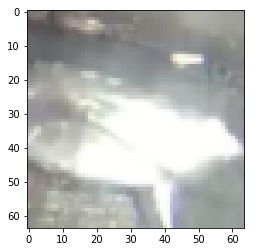

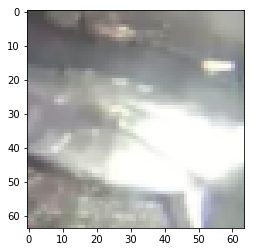

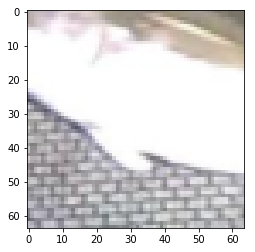

KeyboardInterrupt: 

In [28]:
for img, i in zip(X_train,y_train):
    if i == 1:
        plt.imshow(img.transpose(1,2,0))
        plt.show()

In [29]:
def keras_model_conv2():
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Activation,Flatten
  from keras.layers import Convolution2D, MaxPooling2D
  from keras.optimizers import SGD
  model = Sequential()
  model.add(Convolution2D(16, 5, 5, 
                          border_mode='valid', 
                          input_shape=(3, 64, 64)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(32, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(64, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2))) 
  print model.layers[-1].output_shape  
  model.add(Convolution2D(512, 6,6))
  model.add(Activation('relu'))
  model.add(Convolution2D(256, 1, 1))
  model.add(Activation('relu'))
  model.add(Convolution2D(1, 1, 1))
  model.add(Flatten())
  model.add(Activation('sigmoid'))

    
  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
  return model

In [30]:
model_path = r'C:\Users\Thomas\Documents\MLIP-BigAITuna\model\bounding_boxes.h5'
model = keras_model_conv2()
if os.path.exists(model_path):
    model.load_weights(model_path)


(None, 64, 6, 6)


In [31]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=10,
                             zoom_range=[0.8, 1.2],
                             width_shift_range=0.1,
                             height_shift_range=0.1)
train_gen = datagen.flow(X_train, 
                         y_train)
val_gen = ImageDataGenerator().flow(X_test, y_test)
    

In [53]:
csv_logger = CSVLogger('run4_adam.csv')
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.9)
checkpoint = ModelCheckpoint(filepath='C:/Users/Thomas/Documents/MLIP-BigAITuna/logging/model.{epoch:02d}-{loss}.hdf5', verbose=1, save_best_only=True)

model.fit_generator(train_gen, samples_per_epoch=len(X_train),
                    nb_epoch=30, verbose=2,
                    callbacks=[csv_logger, lr_plateau, checkpoint],
                    validation_data=val_gen, nb_val_samples=len(X_test))

model.save_weights(model_path)

Epoch 1/30
Epoch 00000: val_loss improved from inf to 0.25679, saving model to C:/Users/Thomas/Documents/MLIP-BigAITuna/logging/model.00-0.307131691709.hdf5
31s - loss: 0.3071 - acc: 0.8729 - val_loss: 0.2568 - val_acc: 0.8916
Epoch 2/30
Epoch 00001: val_loss improved from 0.25679 to 0.24110, saving model to C:/Users/Thomas/Documents/MLIP-BigAITuna/logging/model.01-0.281209948507.hdf5
22s - loss: 0.2812 - acc: 0.8810 - val_loss: 0.2411 - val_acc: 0.9005
Epoch 3/30
Epoch 00002: val_loss improved from 0.24110 to 0.24054, saving model to C:/Users/Thomas/Documents/MLIP-BigAITuna/logging/model.02-0.273081863941.hdf5
20s - loss: 0.2731 - acc: 0.8848 - val_loss: 0.2405 - val_acc: 0.9036
Epoch 4/30
Epoch 00003: val_loss improved from 0.24054 to 0.23216, saving model to C:/Users/Thomas/Documents/MLIP-BigAITuna/logging/model.03-0.258973169771.hdf5
20s - loss: 0.2590 - acc: 0.8935 - val_loss: 0.2322 - val_acc: 0.9014
Epoch 5/30
Epoch 00004: val_loss did not improve
20s - loss: 0.2567 - acc: 0.892

In [54]:
def keras_model_conv_test():
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Activation,Flatten
  from keras.layers import Convolution2D, MaxPooling2D
  from keras.optimizers import SGD
  model = Sequential()
  model.add(Convolution2D(16, 5, 5, 
                          border_mode='valid', 
                          input_shape=(3, None, None)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(32, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(64, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2))) 
  print model.layers[-1].output_shape  
  model.add(Convolution2D(512, 6,6))
  model.add(Activation('relu'))
  model.add(Convolution2D(256, 1, 1))
  model.add(Activation('relu'))
  model.add(Convolution2D(1, 1, 1))
  model.add(Activation('sigmoid'))

    
  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
  return model

In [55]:
model_test = keras_model_conv_test()
model_test.load_weights(model_path)

(None, 64, None, None)


In [56]:
# example = train_data.iloc[200]
# filename = '../data/train/{}/{}'.format(example.label, example.filename)
# filename = '../data/train/{}/{}'.format("Alb", "img_01583.jpg")
# image = spm.imread(filename)


image_height = image.shape[0]/2
image_width = image.shape[1]/2
img_resize = spm.imresize(image,size=(image_height,image_width)).transpose(2,0,1).astype('float32')/255
img_resize = img_resize.reshape(1,3,image_height,image_width)

In [57]:
score = model_test.predict_proba(img_resize)

1/1 [==============================] - 0s


In [62]:
heatmap = score[0].transpose(1,2,0).squeeze() > 0.95
print heatmap.shape

(38L, 73L)


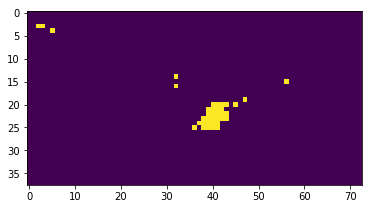

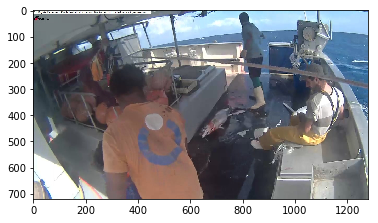

In [63]:
plt.imshow(heatmap)
plt.show()
plt.imshow(image)
plt.show()